# Compare GP and GE

## GE

### House keeping

In [1]:
# change directory to grape 
%cd ../grape

/home/tu/code-py/evolutionary-computation/grape


In [2]:
# Suppressing Warnings:
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Set parameters

POPULATION_SIZE = 500
MAX_GENERATIONS = 50
P_CROSSOVER = 0.8
P_MUTATION = 0.01
HALLOFFAME_SIZE = max(round(0.01*POPULATION_SIZE), 1) #it should be at least 1
ELITE_SIZE = min(round(0.01*POPULATION_SIZE), HALLOFFAME_SIZE)

CODON_CONSUMPTION = "lazy"
GENOME_REPRESENTATION = "list"
MAX_GENOME_LENGTH = None

MAX_INIT_TREE_DEPTH = 13
MIN_INIT_TREE_DEPTH = 3
MAX_TREE_DEPTH = 35
MAX_WRAPS = 0
CODON_SIZE = 255

REPORT_ITEMS = [
    "gen",
    "invalid",
    "avg",
    "std",
    "min",
    "max",
    "best_ind_length",
    "avg_length",
    "best_ind_nodes",
    "avg_nodes",
    "avg_depth",
    "avg_used_codons",
    "best_ind_used_codons",
    "selection_time",
    "generation_time",
]

In [4]:
# random seed
import random


RANDOM_SEED = 42
random.seed(RANDOM_SEED)

### Data

In [5]:
import numpy as np
import pandas as pd


X_train = np.zeros([4, 16], dtype=bool)
Y_train = np.zeros([16,], dtype=bool)

data = pd.read_table(r"datasets/parity4.csv")
for i in range(4):
    for ii in range(16):
        X_train[i, ii] = data["d" + str(i)].iloc[ii]
for i in range(16):
    Y_train[i] = data["output"].iloc[i]

data

,d0,d1,d2,d3,output
0,0,0,0,0,1
1,0,0,0,1,0
2,0,0,1,0,0
3,0,0,1,1,1
4,0,1,0,0,0
5,0,1,0,1,1
6,0,1,1,0,1
7,0,1,1,1,0
8,1,0,0,0,0
9,1,0,0,1,1


### Gramma

In [6]:
import grape 
from functions import not_, and_, or_, nand_, nor_


GRAMMAR_FILE = "grammars/parity4.bnf"

GRAMMAR = grape.Grammar(GRAMMAR_FILE)
GRAMMAR.production_rules

[[['<op>', 'non-terminal', 1, 0, True, 4],
  ['<x>', 'non-terminal', 1, 1, False, 2]],
 [['and_(<e>,<e>)', 'non-terminal', 2, 0, True, 3],
  ['or_(<e>,<e>)', 'non-terminal', 2, 1, True, 3],
  ['nand_(<e>,<e>)', 'non-terminal', 2, 2, True, 3],
  ['nor_(<e>,<e>)', 'non-terminal', 2, 3, True, 3]],
 [['x[0]', 'terminal', 0, 0, False, 1],
  ['x[1]', 'terminal', 0, 1, False, 1],
  ['x[2]', 'terminal', 0, 2, False, 1],
  ['x[3]', 'terminal', 0, 3, False, 1]]]

### Fitness

In [7]:
def geFitness(ind, points):
    x = points[0]
    Y = points[1]

    if ind.invalid:
        return np.nan,

    try:
        pred = eval(ind.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError, MemoryError):
        return np.nan,
    assert np.isrealobj(pred)

    nSample = len(Y)
    compare = np.equal(Y, pred)
    nCorrect = np.sum(compare)
    
    fitness = nSample - nCorrect
    
    return fitness,

### Toolbox

In [8]:
from deap import creator, base, tools

import grape


geBox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)

geBox.register("populationCreator", grape.sensible_initialisation, creator.Individual)
geBox.register("evaluate", geFitness)
geBox.register("select", tools.selTournament, tournsize=6)
geBox.register("mate", grape.crossover_onepoint)
geBox.register("mutate", grape.mutation_int_flip_per_codon)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

### Run GE

In [9]:
import algorithms

gaPopulation = geBox.populationCreator(
    pop_size=POPULATION_SIZE,
    bnf_grammar=GRAMMAR,
    min_init_depth=MIN_INIT_TREE_DEPTH,
    max_init_depth=MAX_INIT_TREE_DEPTH,
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION,
)

hof = tools.HallOfFame(HALLOFFAME_SIZE)



# run GE 
gaPopulation, logbook = algorithms.ge_eaSimpleWithElitism(
    gaPopulation,
    toolbox=geBox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    elite_size=ELITE_SIZE,
    bnf_grammar=GRAMMAR,
    codon_size=CODON_SIZE,
    max_tree_depth=MAX_TREE_DEPTH,
    max_genome_length=MAX_GENOME_LENGTH,
    points_train=[X_train, Y_train],
    codon_consumption=CODON_CONSUMPTION,
    report_items=REPORT_ITEMS,
    genome_representation=GENOME_REPRESENTATION,
    stats=stats,
    halloffame=hof,
    verbose=False,
)

gen = 0 , Best fitness = (np.float64(6.0),)
gen = 1 , Best fitness = (np.float64(6.0),) , Number of invalids = 100
gen = 2 , Best fitness = (np.float64(4.0),) , Number of invalids = 44
gen = 3 , Best fitness = (np.float64(4.0),) , Number of invalids = 29
gen = 4 , Best fitness = (np.float64(4.0),) , Number of invalids = 16
gen = 5 , Best fitness = (np.float64(3.0),) , Number of invalids = 19
gen = 6 , Best fitness = (np.float64(3.0),) , Number of invalids = 10
gen = 7 , Best fitness = (np.float64(3.0),) , Number of invalids = 14
gen = 8 , Best fitness = (np.float64(3.0),) , Number of invalids = 13
gen = 9 , Best fitness = (np.float64(3.0),) , Number of invalids = 9
gen = 10 , Best fitness = (np.float64(2.0),) , Number of invalids = 5
gen = 11 , Best fitness = (np.float64(2.0),) , Number of invalids = 7
gen = 12 , Best fitness = (np.float64(2.0),) , Number of invalids = 10
gen = 13 , Best fitness = (np.float64(2.0),) , Number of invalids = 6
gen = 14 , Best fitness = (np.float64(2.0),) 

### Evaluate

In [10]:
maxFitness, meanFitness, stdFitness, minFitness = logbook.select(
    "max", "avg", "std", "min"
)

bestIndLen = logbook.select("best_ind_length")
avgIndLen = logbook.select("avg_length")

selectionTime = logbook.select("selection_time")
generationTime = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")
avgUsedCodons = logbook.select("avg_used_codons")
bestIndUsedCodons = logbook.select("best_ind_used_codons")

bestIndNodes = logbook.select("best_ind_nodes")
avgNodes = logbook.select("avg_nodes")

avgDepth = logbook.select("avg_depth")

results = pd.DataFrame(
    list(
        zip(
            gen,
            invalid,
            meanFitness,
            stdFitness,
            minFitness,
            maxFitness,
            bestIndLen,
            avgIndLen,
            bestIndNodes,
            avgNodes,
            avgDepth,
            avgUsedCodons,
            bestIndUsedCodons,
            selectionTime,
            generationTime,
        )
    ),
    columns=REPORT_ITEMS,
)

results

,gen,invalid,avg,std,min,max,best_ind_length,avg_length,best_ind_nodes,avg_nodes,avg_depth,avg_used_codons,best_ind_used_codons,selection_time,generation_time
0,0,0,8.000000,0.497996,6.0,10.0,189,102.240000,32,17.540000,9.028000,68.160000,126,0.000000,0.050232
1,1,100,7.822500,0.534784,6.0,9.0,189,138.495000,32,15.677500,10.860000,60.710000,126,0.002260,0.233984
2,2,44,7.662281,0.722434,4.0,10.0,217,177.910088,20,20.890351,14.236842,81.561404,78,0.002406,0.284116
3,3,29,7.628450,0.854585,4.0,10.0,189,204.322718,32,24.352442,16.575372,95.409766,126,0.002148,0.358363
4,4,16,7.440083,1.039770,4.0,10.0,203,217.299587,20,24.752066,17.404959,97.008264,78,0.002085,0.400841
5,5,19,7.045738,1.270973,3.0,12.0,251,232.004158,40,24.544699,17.457380,96.178794,158,0.002500,0.477199
6,6,10,6.975510,1.339895,3.0,10.0,359,243.969388,43,23.924490,17.220408,93.697959,170,0.002195,0.381108
7,7,14,6.786008,1.507010,3.0,11.0,359,263.051440,43,23.440329,17.106996,91.761317,170,0.001993,0.377377
8,8,13,6.835729,1.638135,3.0,13.0,359,282.778234,43,25.273101,18.002053,99.092402,170,0.002103,0.423570
9,9,9,6.625255,1.721463,3.0,11.0,359,310.014257,43,27.012220,18.429735,106.048880,170,0.002080,0.482029


#### Best individual

In [11]:
import textwrap

best = hof[0].phenotype

print("Best individual:\n", "\n".join(textwrap.wrap(best, 80)))
print()
print("Training Fitness:", hof[0].fitness.values[0])

print("Depth:", hof[0].depth)
print("Genome length:", len(hof[0].genome))
print(f"Used portion of genome: {hof[0].used_codons / len(hof[0].genome):.2f}")


Best individual:
 nand_(nor_(nor_(nor_(nor_(x[2],x[1]),and_(x[1],x[2])),nor_(nor_(x[0],x[3]),and_(
x[0],x[3]))),and_(nor_(nor_(x[1],x[2]),nor_(x[3],x[0])),nor_(and_(x[1],x[2]),nan
d_(x[1],and_(nand_(and_(x[2],x[2]),and_(x[0],x[3])),nand_(and_(x[0],x[3]),or_(x[
1],x[1]))))))),or_(nand_(or_(and_(or_(x[2],nor_(nor_(x[2],x[1]),and_(x[1],x[2]))
),nor_(nor_(x[0],x[3]),and_(x[0],x[3]))),and_(nor_(nor_(x[1],nand_(nor_(x[0],x[0
]),nor_(and_(x[1],x[2]),nand_(x[1],and_(nand_(and_(x[2],x[2]),and_(x[0],x[0])),n
and_(x[3],x[0])))))),nor_(and_(x[1],x[2]),nand_(x[1],and_(nor_(and_(x[2],x[2]),n
or_(x[1],nand_(and_(x[1],nand_(x[3],x[1])),and_(or_(x[3],x[2]),x[2])))),x[0]))))
,and_(x[0],x[1]))),x[2]),x[1]))

Training Fitness: 0.0
Depth: 31
Genome length: 770
Used portion of genome: 0.31


<ErrorbarContainer object of 3 artists>

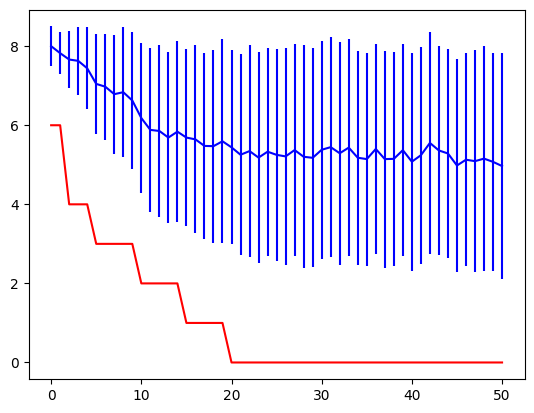

In [12]:
from matplotlib import pyplot as plt


plt.figure()
plt.plot(gen, minFitness, label="Best Fitness", color="red")
plt.errorbar(gen, meanFitness, yerr= stdFitness, label="Mean Fitness", color="blue")

## GP

In [13]:
# back to normal directory
%cd -

/home/tu/code-py/evolutionary-computation/ES4


### House keeping

In [14]:
MIN_INIT_TREE_HEIGHT = MIN_INIT_TREE_DEPTH
MAX_INIT_TREE_HEIGHT = MAX_INIT_TREE_DEPTH
LIMIT_TREE_HEIGHT = MAX_TREE_DEPTH
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

### Primative Set

In [15]:
import operator
from deap import gp


pset = gp.PrimitiveSet("MAIN", 4)

def opNand(a, b):
    return np.logical_not(np.logical_and(a, b))
def opNor(a, b):
    return np.logical_not(np.logical_or(a, b))

# not_, and_, or_, nand_, nor_
pset.addPrimitive(operator.not_, 1)
pset.addPrimitive(operator.and_, 2)
pset.addPrimitive(operator.or_, 2)
pset.addPrimitive(opNand, 2)
pset.addPrimitive(opNor, 2)

pset.addTerminal(np.bool_(1))
pset.addTerminal(np.bool_(0))

### Fitness

In [16]:
def gpFitness(ind, toolbox, points):
    x,Y = points
    
    func = toolbox.compile(expr=ind)

    try:
        pred = func(*x)
    except Exception:
        return len(Y),

    assert np.isrealobj(pred)

    nSample = len(Y)
    compare = np.equal(Y, pred)
    nCorrect = np.sum(compare)

    fitness = nSample - nCorrect

    return fitness,

### Toolbox

In [17]:
import operator


gpBox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

gpBox.register("expr", gp.genHalfAndHalf, pset=pset, min_=MIN_INIT_TREE_HEIGHT, max_=MAX_INIT_TREE_HEIGHT)
gpBox.register("individualCreator", tools.initIterate, creator.Individual, gpBox.expr)
gpBox.register("populationCreator", tools.initRepeat, list, gpBox.individualCreator)
gpBox.register("compile", gp.compile, pset=pset)
gpBox.register("evaluate", gpFitness, toolbox=gpBox, points=[X_train, Y_train])

gpBox.register("select", tools.selTournament, tournsize=6)
gpBox.register("mate", gp.cxOnePoint)
gpBox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
gpBox.register("mutate", gp.mutUniform, expr=gpBox.expr_mut, pset=pset)

gpBox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
gpBox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))

### Run GP

In [18]:
from elitism import eaSimpleWithElitism


gpPopulation = gpBox.populationCreator(n=POPULATION_SIZE)
hof = tools.HallOfFame(HALLOFFAME_SIZE)

gpPopulation, logbook = eaSimpleWithElitism(
    gpPopulation,
    gpBox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    stats=stats,
    halloffame=hof,
    verbose=False,
)

### Evaluate

In [19]:
maxFitness, meanFitness, stdFitness, minFitness = logbook.select(
    "max", "avg", "std", "min"
)

bestIndLen = logbook.select("best_ind_length")
avgIndLen = logbook.select("avg_length")

selectionTime = logbook.select("selection_time")
generationTime = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")
avgUsedCodons = logbook.select("avg_used_codons")
bestIndUsedCodons = logbook.select("best_ind_used_codons")

bestIndNodes = logbook.select("best_ind_nodes")
avgNodes = logbook.select("avg_nodes")

avgDepth = logbook.select("avg_depth")

results = pd.DataFrame(
    list(
        zip(
            gen,
            invalid,
            meanFitness,
            stdFitness,
            minFitness,
            maxFitness,
            bestIndLen,
            avgIndLen,
            bestIndNodes,
            avgNodes,
            avgDepth,
            avgUsedCodons,
            bestIndUsedCodons,
            selectionTime,
            generationTime,
        )
    ),
    columns=REPORT_ITEMS,
)

results

,gen,invalid,avg,std,min,max,best_ind_length,avg_length,best_ind_nodes,avg_nodes,avg_depth,avg_used_codons,best_ind_used_codons,selection_time,generation_time
0,0,None,15.918,0.816870,7.0,16.0,None,None,None,None,None,None,None,None,None
1,1,None,15.598,1.752825,7.0,16.0,None,None,None,None,None,None,None,None,None
2,2,None,14.538,3.101057,7.0,16.0,None,None,None,None,None,None,None,None,None
3,3,None,10.806,3.869931,7.0,16.0,None,None,None,None,None,None,None,None,None
4,4,None,7.844,0.680929,7.0,16.0,None,None,None,None,None,None,None,None,None
5,5,None,7.620,0.748064,7.0,16.0,None,None,None,None,None,None,None,None,None
6,6,None,7.484,0.863565,6.0,16.0,None,None,None,None,None,None,None,None,None
7,7,None,7.440,0.783837,6.0,16.0,None,None,None,None,None,None,None,None,None
8,8,None,7.360,0.765768,6.0,16.0,None,None,None,None,None,None,None,None,None
9,9,None,7.088,0.896803,6.0,16.0,None,None,None,None,None,None,None,None,None


#### Best individual

<ErrorbarContainer object of 3 artists>

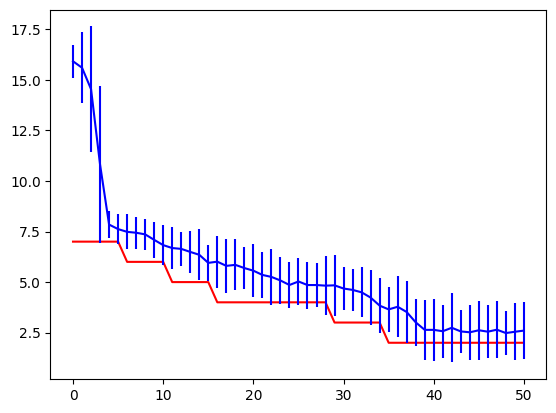

In [20]:
plt.figure()
plt.plot(gen, minFitness, label="Best Fitness", color="red")
plt.errorbar(gen, meanFitness, yerr= stdFitness, label="Mean Fitness", color="blue")

## Compare 

### 0.8 - 0.01

In [ ]:
P_CROSSOVER = 0.8
P_MUTATION = 0.01

#### GP

<ErrorbarContainer object of 3 artists>

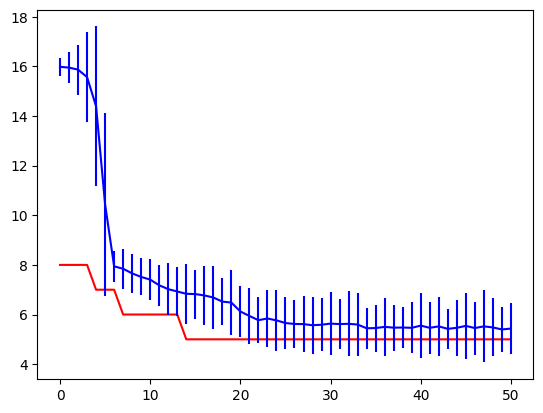

In [24]:
gpPopulation = gpBox.populationCreator(n=POPULATION_SIZE)
gpHof = tools.HallOfFame(HALLOFFAME_SIZE)

gpPopulation, logbook = eaSimpleWithElitism(
    gpPopulation,
    gpBox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    stats=stats,
    halloffame=gpHof,
    verbose=False,
)

maxFitness, meanFitness, stdFitness, minFitness = logbook.select(
    "max", "avg", "std", "min"
)

plt.figure()
plt.plot(gen, minFitness, label="Best Fitness", color="red")
plt.errorbar(gen, meanFitness, yerr= stdFitness, label="Mean Fitness", color="blue")

#### GE

gen = 0 , Best fitness = (np.float64(6.0),)
gen = 1 , Best fitness = (np.float64(5.0),) , Number of invalids = 109
gen = 2 , Best fitness = (np.float64(5.0),) , Number of invalids = 45
gen = 3 , Best fitness = (np.float64(5.0),) , Number of invalids = 22
gen = 4 , Best fitness = (np.float64(5.0),) , Number of invalids = 16
gen = 5 , Best fitness = (np.float64(5.0),) , Number of invalids = 24
gen = 6 , Best fitness = (np.float64(5.0),) , Number of invalids = 15
gen = 7 , Best fitness = (np.float64(5.0),) , Number of invalids = 8
gen = 8 , Best fitness = (np.float64(5.0),) , Number of invalids = 17
gen = 9 , Best fitness = (np.float64(5.0),) , Number of invalids = 9
gen = 10 , Best fitness = (np.float64(5.0),) , Number of invalids = 14
gen = 11 , Best fitness = (np.float64(4.0),) , Number of invalids = 14
gen = 12 , Best fitness = (np.float64(4.0),) , Number of invalids = 8
gen = 13 , Best fitness = (np.float64(4.0),) , Number of invalids = 4
gen = 14 , Best fitness = (np.float64(4.0),) 

<ErrorbarContainer object of 3 artists>

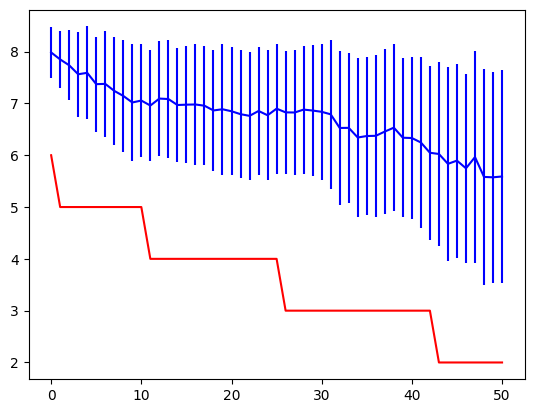

In [26]:
gePopulation = geBox.populationCreator(
    pop_size=POPULATION_SIZE,
    bnf_grammar=GRAMMAR,
    min_init_depth=MIN_INIT_TREE_DEPTH,
    max_init_depth=MAX_INIT_TREE_DEPTH,
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION,
)
geHof = tools.HallOfFame(HALLOFFAME_SIZE)

gePopulation, logbook = algorithms.ge_eaSimpleWithElitism(
    gePopulation,
    toolbox=geBox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    elite_size=ELITE_SIZE,
    bnf_grammar=GRAMMAR,
    codon_size=CODON_SIZE,
    max_tree_depth=MAX_TREE_DEPTH,
    max_genome_length=MAX_GENOME_LENGTH,
    points_train=[X_train, Y_train],
    codon_consumption=CODON_CONSUMPTION,
    report_items=REPORT_ITEMS,
    genome_representation=GENOME_REPRESENTATION,
    stats=stats,
    halloffame=geHof,
    verbose=False,
)

maxFitness, meanFitness, stdFitness, minFitness = logbook.select(
    "max", "avg", "std", "min"
)

plt.figure()
plt.plot(gen, minFitness, label="Best Fitness", color="red")
plt.errorbar(gen, meanFitness, yerr= stdFitness, label="Mean Fitness", color="blue")


### 0.9 - 0.05

In [ ]:
P_CROSSOVER = 0.9
P_MUTATION = 0.05

#### GP

<ErrorbarContainer object of 3 artists>

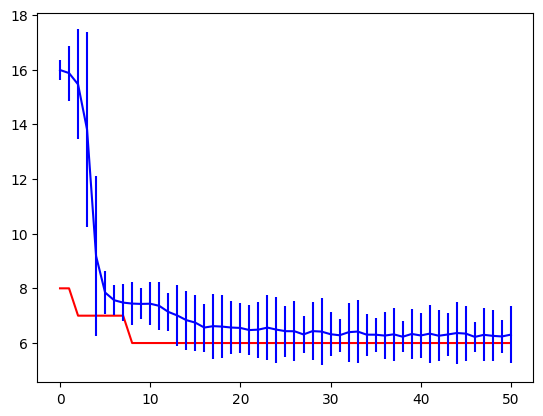

In [27]:
gpPopulation = gpBox.populationCreator(n=POPULATION_SIZE)
gpHof = tools.HallOfFame(HALLOFFAME_SIZE)

gpPopulation, logbook = eaSimpleWithElitism(
    gpPopulation,
    gpBox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    stats=stats,
    halloffame=gpHof,
    verbose=False,
)

maxFitness, meanFitness, stdFitness, minFitness = logbook.select(
    "max", "avg", "std", "min"
)

plt.figure()
plt.plot(gen, minFitness, label="Best Fitness", color="red")
plt.errorbar(gen, meanFitness, yerr= stdFitness, label="Mean Fitness", color="blue")

#### GE

gen = 0 , Best fitness = (np.float64(2.0),)
gen = 1 , Best fitness = (np.float64(2.0),) , Number of invalids = 103
gen = 2 , Best fitness = (np.float64(2.0),) , Number of invalids = 57
gen = 3 , Best fitness = (np.float64(2.0),) , Number of invalids = 39
gen = 4 , Best fitness = (np.float64(2.0),) , Number of invalids = 14
gen = 5 , Best fitness = (np.float64(2.0),) , Number of invalids = 12
gen = 6 , Best fitness = (np.float64(2.0),) , Number of invalids = 6
gen = 7 , Best fitness = (np.float64(2.0),) , Number of invalids = 7
gen = 8 , Best fitness = (np.float64(2.0),) , Number of invalids = 3
gen = 9 , Best fitness = (np.float64(2.0),) , Number of invalids = 5
gen = 10 , Best fitness = (np.float64(2.0),) , Number of invalids = 3
gen = 11 , Best fitness = (np.float64(2.0),) , Number of invalids = 0
gen = 12 , Best fitness = (np.float64(2.0),) , Number of invalids = 0
gen = 13 , Best fitness = (np.float64(2.0),) , Number of invalids = 2
gen = 14 , Best fitness = (np.float64(2.0),) , Nu

<ErrorbarContainer object of 3 artists>

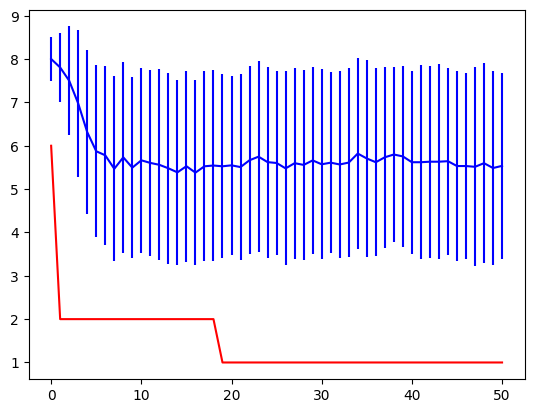

In [28]:
gePopulation = geBox.populationCreator(
    pop_size=POPULATION_SIZE,
    bnf_grammar=GRAMMAR,
    min_init_depth=MIN_INIT_TREE_DEPTH,
    max_init_depth=MAX_INIT_TREE_DEPTH,
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION,
)

gePopulation, logbook = algorithms.ge_eaSimpleWithElitism(
    gePopulation,
    toolbox=geBox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    elite_size=ELITE_SIZE,
    bnf_grammar=GRAMMAR,
    codon_size=CODON_SIZE,
    max_tree_depth=MAX_TREE_DEPTH,
    max_genome_length=MAX_GENOME_LENGTH,
    points_train=[X_train, Y_train],
    codon_consumption=CODON_CONSUMPTION,
    report_items=REPORT_ITEMS,
    genome_representation=GENOME_REPRESENTATION,
    stats=stats,
    halloffame=geHof,
    verbose=False,
)

maxFitness, meanFitness, stdFitness, minFitness = logbook.select(
    "max", "avg", "std", "min"
)

plt.figure()
plt.plot(gen, minFitness, label="Best Fitness", color="red")
plt.errorbar(gen, meanFitness, yerr= stdFitness, label="Mean Fitness", color="blue")
